In [1]:
import requests
import geopandas as gpd
from download import download
import osmnx as ox
import momepy
import libpysal
import numpy as np
import warnings
import pandas as pd
import tobler
import pandana
import mapclassify

from dask.distributed import Client, LocalCluster
from tqdm import tqdm

import utils
from shapely.geometry import box, mapping
from numpy import percentile
import os
import subprocess
import xarray
import rioxarray
import geopandas
import rasterstats


import utils.momepy
import utils.tobler

## buildings, lots from open data portal

In [19]:
path = "../../urbangrammar_samba/sp_sig_concept/medellin/buildings"
blg = download("https://opendata.arcgis.com/datasets/7e7cd8414e7f456cb3605b7f461d4aa0_5.zip", path, kind="zip")

Creating data folder...

file_sizes: 150MB [00:05, 28.4MB/s]                                             
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/buildings


In [20]:
path = "../../urbangrammar_samba/sp_sig_concept/medellin/lots"
lots = download("https://opendata.arcgis.com/datasets/040e022660b14622a072915530f93cf9_8.zip", path, kind="zip")

Creating data folder...

file_sizes: 92.8MB [00:03, 30.6MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/lots


In [35]:
buildings = gpd.read_file(blg)

In [22]:
plots = gpd.read_file(lots)

In [36]:
buildings = buildings[["NUMERO_PIS", "geometry"]].rename(columns={"NUMERO_PIS": "n_floors"})

In [37]:
buildings["point"] = buildings.representative_point()
buildings = buildings.set_geometry("point")

In [38]:
%time join = gpd.sjoin(buildings, plots[["geometry"]], how="left")

CPU times: user 34.6 s, sys: 0 ns, total: 34.6 s
Wall time: 34.6 s


In [39]:
join.head(10)

,n_floors,geometry,point,index_right
0,2,"POLYGON ((-75.54168 6.29355, -75.54164 6.29349...",POINT (-75.54171 6.29353),182749.0
1,1,"POLYGON ((-75.54163 6.29348, -75.54162 6.29341...",POINT (-75.54163 6.29345),NaN
2,2,"POLYGON ((-75.54188 6.29348, -75.54188 6.29348...",POINT (-75.54188 6.29342),NaN
3,2,"POLYGON ((-75.54182 6.29289, -75.54186 6.29267...",POINT (-75.54195 6.29275),277957.0
4,1,"POLYGON ((-75.54278 6.29732, -75.54280 6.29730...",POINT (-75.54280 6.29732),198347.0
5,1,"POLYGON ((-75.54375 6.30094, -75.54373 6.30094...",POINT (-75.54371 6.30092),208626.0
6,1,"POLYGON ((-75.54272 6.30088, -75.54274 6.30083...",POINT (-75.54277 6.30089),180661.0
7,1,"POLYGON ((-75.54394 6.30074, -75.54396 6.30071...",POINT (-75.54398 6.30074),276046.0
8,1,"POLYGON ((-75.54403 6.30072, -75.54399 6.30068...",POINT (-75.54403 6.30065),208629.0
9,2,"POLYGON ((-75.54414 6.30064, -75.54410 6.30061...",POINT (-75.54413 6.30061),180257.0


In [41]:
join_notna = join[~join.index_right.isna()]

In [42]:
%%time
dissolved = join_notna.set_geometry("geometry").drop(columns="point").dissolve("index_right", aggfunc='median')

CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 22s


In [60]:
buildings = dissolved.reset_index().drop(columns="index_right")

In [61]:
buildings = buildings[~buildings.geometry.isna()].explode().reset_index(drop=True)

In [62]:
buildings = buildings.replace({0.0: 1, 0.5: 1})

In [63]:
buildings = buildings.reset_index(drop=True)
buildings['uID'] = range(len(buildings))
buildings["geometry"] = buildings.geometry.buffer(0)

In [64]:
buildings.geom_type.value_counts()

Polygon    338181
dtype: int64

In [65]:
buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/buildings.pq")

<ipython-input-65-0929575016ac>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/buildings.pq")


In [66]:
buildings.is_valid.value_counts()

True    338181
dtype: int64

### limits

In [68]:
path = "../../urbangrammar_samba/sp_sig_concept/medellin/limits"
download("https://opendata.arcgis.com/datasets/283d1d14584641c9971edbd2f695e502_6.zip", path, kind="zip")

Creating data folder...

file_sizes: 1.07MB [00:00, 2.37MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/limits


'../../urbangrammar_samba/sp_sig_concept/medellin/limits'

In [2]:
limits = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/medellin/limits")
polygon = limits.unary_union

In [71]:
%%time
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_polygon(polygon, network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = f'../../urbangrammar_samba/sp_sig_concept/medellin/roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

CPU times: user 31.8 s, sys: 82.6 ms, total: 31.9 s
Wall time: 1min 8s


<timed exec>:8: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


In [72]:
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_polygon(polygon, tags)
path = f'../../urbangrammar_samba/sp_sig_concept/medellin/water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

<ipython-input-72-acd792f6f0a3>:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf[['natural', 'geometry']].to_parquet(path)


In [73]:
tags = {'railway': True}
gdf = ox.geometries_from_polygon(polygon, tags)
gdf = gdf[gdf.geom_type == 'LineString']
gdf = gdf[gdf.tunnel != 'yes']
path = f'../../urbangrammar_samba/sp_sig_concept/medellin/railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

<ipython-input-73-27c487db65a2>:6: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf[['railway', 'geometry']].to_parquet(path)


In [74]:
### preprocessing of barriers

In [3]:
roads = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/medellin/roads_osm.pq').to_crs(3117)

In [83]:
roads.crs

<Projected CRS: EPSG:3117>
Name: MAGNA-SIRGAS / Colombia East Central zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - 72°35'W to 69°35'W
- bounds: (-72.59, -4.23, -69.58, 12.52)
Coordinate Operation:
- name: Colombia MAGNA East Central zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [84]:
roads.geom_type.value_counts()

LineString    27725
dtype: int64

In [4]:
railway = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/medellin/railway_osm.pq').to_crs(3117)

In [86]:
railway.geom_type.unique()

array(['LineString'], dtype=object)

In [5]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

In [6]:
water = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/water_osm.pq").to_crs(3117)

In [7]:
water.geom_type.value_counts()

Polygon    65
Point       1
dtype: int64

In [8]:
water = water[water.geom_type == "Polygon"]
water.geometry = water.geometry.boundary

## Generate geography

### Enclosures

In [9]:
limit = limits.to_crs(3117)

In [10]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=limit, additional_barriers=[extended_railway, water])

CPU times: user 2.36 s, sys: 71.1 ms, total: 2.43 s
Wall time: 2.39 s


<AxesSubplot:>

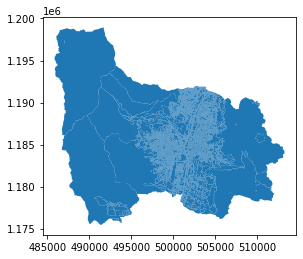

In [98]:
enclosures.plot()

In [99]:
enclosures.is_valid.all()

True

In [11]:
enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/enclosures.pq")

<ipython-input-11-1de7bae739d2>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/enclosures.pq")


In [12]:
client = Client(LocalCluster(n_workers=16))
client

Client Scheduler: tcp://127.0.0.1:41457 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [13]:
buildings = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/buildings.pq")

In [14]:
buildings = buildings.to_crs(3117)

In [15]:
buildings.is_valid.all()

False

In [16]:
buildings.geometry = buildings.geometry.buffer(0)

In [17]:
buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/buildings.pq")

<ipython-input-17-0929575016ac>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/buildings.pq")


In [18]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

/opt/conda/lib/python3.8/site-packages/distributed/worker.py:3373: UserWarning: Large object of size 105.07 MB detected in task graph: 
  ([         eID                                     ...  0.05, 'uID'],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 1min 15s, sys: 9.17 s, total: 1min 24s
Wall time: 8min 46s


In [19]:
tessellation = tess.tessellation

In [20]:
tessellation['tID'] = range(len(tessellation))
tessellation.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/tessellation.pq")

<ipython-input-20-ae7a10c69ca3>:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tessellation.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/tessellation.pq")


## Primary morphometric characters

In [21]:
tess = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/tessellation.pq")
blg = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/buildings.pq")
streets = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/medellin/roads_osm.pq').to_crs(3117)
enclosures = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/enclosures.pq")

In [22]:
tess.crs == blg.crs == streets.crs == enclosures.crs

True

In [23]:
tess = tess.rename_geometry("tessellation").merge(blg[['uID', 'geometry']].rename_geometry("buildings"), on='uID', how='left')

In [24]:
tess

,uID,tessellation,eID,tID,buildings
0,93762.0,"POLYGON ((502018.719 1180644.567, 502018.955 1...",0,0,"POLYGON ((502021.345 1180673.678, 502020.037 1..."
1,93763.0,"POLYGON ((502020.261 1180663.879, 502019.824 1...",0,1,"POLYGON ((502022.735 1180667.440, 502021.533 1..."
2,93773.0,"POLYGON ((502065.088 1180656.807, 502065.010 1...",0,2,"POLYGON ((502065.089 1180661.593, 502063.187 1..."
3,108053.0,"POLYGON ((502030.501 1180692.557, 502029.092 1...",0,3,"POLYGON ((502040.779 1180719.063, 502032.986 1..."
4,108263.0,"POLYGON ((501994.139 1180653.183, 501992.411 1...",0,4,"POLYGON ((501994.980 1180660.639, 501996.678 1..."
...,...,...,...,...,...
337732,NaN,"POLYGON ((502794.237 1189037.237, 502784.158 1...",11172,337732,None
337733,NaN,"POLYGON ((502782.236 1189042.505, 502770.661 1...",11173,337733,None
337734,NaN,"POLYGON ((502796.494 1189009.548, 502803.111 1...",11174,337734,None
337735,NaN,"POLYGON ((500181.679 1185592.112, 500176.099 1...",11175,337735,None


In [25]:
blg = tess.set_geometry('buildings').dropna()

In [26]:
%time blg['sdbAre'] = momepy.Area(blg).series
%time blg['sdbPer'] = momepy.Perimeter(blg).series
%time blg['sdbCoA'] = momepy.CourtyardArea(blg, 'sdbAre').series

%time blg['ssbCCo'] = momepy.CircularCompactness(blg, 'sdbAre').series
%time blg['ssbCor'] = momepy.Corners(blg).series
%time blg['ssbSqu'] = momepy.Squareness(blg).series
%time blg['ssbERI'] = momepy.EquivalentRectangularIndex(blg, 'sdbAre', 'sdbPer').series
%time blg['ssbElo'] = momepy.Elongation(blg).series

CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 134 ms
CPU times: user 132 ms, sys: 1.22 ms, total: 133 ms
Wall time: 114 ms
CPU times: user 7.59 s, sys: 1.12 s, total: 8.71 s
Wall time: 7.85 s


  0%|          | 208/333227 [00:00<02:40, 2079.31it/s]

CPU times: user 30.1 s, sys: 2.46 s, total: 32.6 s
Wall time: 30.2 s


  0%|          | 818/333227 [00:00<03:24, 1623.28it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:766: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 104/333227 [00:00<05:20, 1039.03it/s]

CPU times: user 2min 7s, sys: 40.8 s, total: 2min 48s
Wall time: 2min 8s


  0%|          | 235/333227 [00:00<05:01, 1103.72it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 835/333227 [00:01<07:33, 732.68it/s] /opt/conda/lib/python3.8/site-packages/momepy/shape.py:854: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
100%|██████████| 333227/333227 [04:03<00:00, 1366.01it/s]


CPU times: user 4min, sys: 1min 32s, total: 5min 33s
Wall time: 4min 4s
CPU times: user 2min 48s, sys: 16.4 s, total: 3min 4s
Wall time: 2min 50s
CPU times: user 2min 49s, sys: 15.9 s, total: 3min 4s
Wall time: 2min 50s


In [27]:
%time cencon = momepy.CentroidCorners(blg)
blg['ssbCCM'] = cencon.mean
blg['ssbCCD'] = cencon.std

%time blg['stbOri'] = momepy.Orientation(blg).series
 
%time tess['stcOri'] = momepy.Orientation(tess).series

  0%|          | 842/333227 [00:00<06:12, 892.17it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:1074: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 155/333227 [00:00<03:35, 1544.96it/s]

CPU times: user 3min 47s, sys: 40.2 s, total: 4min 27s
Wall time: 3min 49s


  0%|          | 55/337737 [00:00<10:15, 548.77it/s]

CPU times: user 3min 9s, sys: 18.4 s, total: 3min 28s
Wall time: 3min 10s


100%|██████████| 337737/337737 [08:24<00:00, 669.53it/s] 


CPU times: user 8min 23s, sys: 45.9 s, total: 9min 9s
Wall time: 8min 24s


In [28]:
tess = tess.merge(blg[['tID', 'stbOri']], on='tID', how='left')

In [29]:
%time tess['stbCeA'] = (tess['stbOri'] - tess['stcOri']).abs()

CPU times: user 2.89 ms, sys: 470 µs, total: 3.36 ms
Wall time: 1.96 ms


In [30]:
%time tess['sdcLAL'] = momepy.LongestAxisLength(tess).series
%time tess['sdcAre'] = momepy.Area(tess).series
%time tess['sscCCo'] = momepy.CircularCompactness(tess, 'sdcAre').series
%time tess['sscERI'] = momepy.EquivalentRectangularIndex(tess, 'sdcAre').series

%time tess['sicCAR'] = tess.buildings.area / tess['sdcAre']

CPU times: user 1min 7s, sys: 6.49 s, total: 1min 13s
Wall time: 1min 5s
CPU times: user 368 ms, sys: 5.22 ms, total: 373 ms
Wall time: 315 ms
CPU times: user 1min 13s, sys: 4.87 s, total: 1min 18s
Wall time: 1min 12s
CPU times: user 7min 53s, sys: 44.4 s, total: 8min 37s
Wall time: 7min 56s
CPU times: user 129 ms, sys: 5.57 ms, total: 134 ms
Wall time: 112 ms


In [31]:
%time blg["mtbSWR"] = momepy.SharedWallsRatio(blg).series

CPU times: user 1min 15s, sys: 658 ms, total: 1min 15s
Wall time: 1min 6s


In [32]:
%time queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tess, ids="tID", geom_col='tessellation')

CPU times: user 3min 51s, sys: 13 s, total: 4min 4s
Wall time: 3min 55s


In [33]:
%time tess["mtbAli"] = momepy.Alignment(tess.set_geometry("buildings"), queen_1, "tID", "stbOri").series

100%|██████████| 337737/337737 [02:23<00:00, 2357.08it/s]


CPU times: user 2min 24s, sys: 7.14 s, total: 2min 31s
Wall time: 2min 23s


In [34]:
%time tess["mtbNDi"] = utils.momepy.NeighborDistance(tess.set_geometry("buildings"), queen_1, "tID").series
%time tess["mtcWNe"] = momepy.Neighbors(tess, queen_1, "tID", weighted=True).series
%time tess["mdcAre"] = momepy.CoveredArea(tess, queen_1, "tID").series

  2%|▏         | 6808/337737 [00:00<00:04, 68069.19it/s]

CPU times: user 3min 20s, sys: 10.7 s, total: 3min 31s
Wall time: 3min 12s


100%|██████████| 337737/337737 [00:04<00:00, 77583.45it/s]


CPU times: user 4.47 s, sys: 282 ms, total: 4.75 s
Wall time: 4.42 s


100%|██████████| 337737/337737 [00:58<00:00, 5733.72it/s]


CPU times: user 1min, sys: 6.18 s, total: 1min 6s
Wall time: 59.3 s


In [35]:
%time blg_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blg, geom_col='buildings', silence_warnings=True)
 
%time blg["ldbPWL"] = momepy.PerimeterWall(blg, blg_q1).series

CPU times: user 31.7 s, sys: 1.7 s, total: 33.4 s
Wall time: 31.6 s


100%|██████████| 333227/333227 [00:00<00:00, 3090933.77it/s]

CPU times: user 2min 57s, sys: 4.05 s, total: 3min 1s
Wall time: 2min 43s


In [36]:
%time blg["libNCo"] = utils.momepy.Courtyards(blg, spatial_weights=blg_q1).series

100%|██████████| 333227/333227 [03:06<00:00, 1783.17it/s]


CPU times: user 3min 23s, sys: 5.03 s, total: 3min 28s
Wall time: 3min 6s


In [37]:
%time queen_3 = momepy.sw_high(k=3, weights=queen_1)
%time tess['ltbIBD'] = utils.momepy.MeanInterbuildingDistance(tess.set_geometry('buildings'), queen_1, 'tID', queen_3).series

CPU times: user 31.6 s, sys: 721 ms, total: 32.3 s
Wall time: 31.9 s


  0%|          | 136/337737 [00:00<04:08, 1359.10it/s]

Computing mean interbuilding distances...


 99%|█████████▉| 333809/337737 [04:57<00:08, 460.14it/s] /home/jovyan/work/spatial_signatures_concept/code/utils/momepy.py:1099: RuntimeWarning: Mean of empty slice
  np.nanmean([x[-1] for x in list(sub.edges.data("weight"))])
100%|██████████| 337737/337737 [05:04<00:00, 1108.37it/s]


CPU times: user 5min 41s, sys: 5.17 s, total: 5min 46s
Wall time: 5min 34s


In [41]:
# get nid and primary nid here
%time links = utils.momepy.get_network_ratio(tess, streets)
tess[['edgeID_keys', 'edgeID_values']] = links
keys = tess.edgeID_values.apply(lambda a: np.argmax(a))
tess['edgeID_primary'] = [inds[i] for inds, i in zip(tess.edgeID_keys, keys)]
blg = blg.merge(tess[['tID', 'edgeID_primary']], on='tID', how='left')
streets['edgeID_primary'] = range(len(streets))

CPU times: user 18min 10s, sys: 15.3 s, total: 18min 25s
Wall time: 16min 2s


In [42]:
%time streets["sdsLen"] = momepy.Perimeter(streets).series
%time tess["stcSAl"] = momepy.StreetAlignment(tess, streets, "stcOri", "edgeID_primary").series
%time blg["stbSAl"] = momepy.StreetAlignment(blg, streets, "stbOri", "edgeID_primary").series

CPU times: user 5.57 ms, sys: 456 µs, total: 6.02 ms
Wall time: 2.87 ms
CPU times: user 941 ms, sys: 94 ms, total: 1.04 s
Wall time: 961 ms
CPU times: user 970 ms, sys: 86.3 ms, total: 1.06 s
Wall time: 973 ms


In [43]:
%time profile = momepy.StreetProfile(streets, blg, distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd

100%|██████████| 27725/27725 [20:29<00:00, 22.55it/s]  

CPU times: user 21min 4s, sys: 1min 32s, total: 22min 37s
Wall time: 20min 29s


In [44]:
%time streets["sssLin"] = momepy.Linearity(streets).series

CPU times: user 596 ms, sys: 52.8 ms, total: 649 ms
Wall time: 609 ms


In [45]:
%%time 
# Area Covered by each edge
vals = {x:[] for x in range(len(streets))}
for i, keys in enumerate(tess.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(tess.sdcAre.iloc[inds].sum())
streets['sdsAre'] = area_sums

CPU times: user 3.25 s, sys: 452 ms, total: 3.7 s
Wall time: 3.21 s


In [46]:
%%time
# Buildings per meter
bpm = []
for inds, l in zip(vals.values(), streets.sdsLen):
    bpm.append(tess.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
streets['sisBpM'] = bpm

CPU times: user 9.63 s, sys: 497 ms, total: 10.1 s
Wall time: 9.6 s


In [47]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
 
streets["misRea"] = momepy.Reached(
    streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1, mode="count"
).series
streets["mdsAre"] = momepy.Reached(streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1,
                               mode="sum").series

100%|██████████| 27725/27725 [01:57<00:00, 236.62it/s]


In [48]:
%time graph = momepy.gdf_to_nx(streets)
 
print("node degree")
graph = momepy.node_degree(graph)
 
print("subgraph")
graph = momepy.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)
print("cds length")
graph = momepy.cds_length(graph, radius=3, name="ldsCDL")
 
print("clustering")
graph = momepy.clustering(graph, name="xcnSCl")
 
print("mean_node_dist")
graph = momepy.mean_node_dist(graph, name="mtdMDi")
 
%time nodes, edges, sw = momepy.nx_to_gdf(graph, spatial_weights=True)

CPU times: user 4.27 s, sys: 388 ms, total: 4.65 s
Wall time: 4.31 s
node degree
subgraph


100%|██████████| 19475/19475 [00:29<00:00, 659.12it/s] 


cds length


100%|██████████| 19475/19475 [00:10<00:00, 1898.49it/s]


clustering
mean_node_dist


100%|██████████| 19475/19475 [00:00<00:00, 70971.00it/s]
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 146 disconnected components.
  warnings.warn(message)


CPU times: user 778 ms, sys: 61.3 ms, total: 839 ms
Wall time: 787 ms


In [49]:
%time edges_w3 = momepy.sw_high(k=3, gdf=edges)
%time edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series
 
%time nodes_w5 = momepy.sw_high(k=5, weights=sw)
%time nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5).series
nodes["linWID"] = momepy.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree"
).series

  5%|▍         | 1255/27725 [00:00<00:02, 12541.97it/s]

CPU times: user 3.72 s, sys: 103 ms, total: 3.82 s
Wall time: 3.71 s


100%|██████████| 27725/27725 [00:02<00:00, 11327.09it/s]


CPU times: user 2.51 s, sys: 491 ms, total: 3 s
Wall time: 2.46 s


  1%|          | 98/19475 [00:00<00:19, 975.57it/s]

CPU times: user 1.48 s, sys: 29 ms, total: 1.51 s
Wall time: 1.48 s


  0%|          | 61/19475 [00:00<00:31, 609.58it/s]

CPU times: user 21.7 s, sys: 650 ms, total: 22.3 s
Wall time: 20.1 s


100%|██████████| 19475/19475 [00:33<00:00, 583.51it/s]


In [50]:
enclosures["ldeAre"] = momepy.Area(enclosures).series
enclosures["ldePer"] = momepy.Perimeter(enclosures).series
enclosures["lseCCo"] = momepy.CircularCompactness(enclosures, "ldeAre").series
enclosures["lseERI"] = momepy.EquivalentRectangularIndex(enclosures, "ldeAre", "ldePer").series
enclosures["lseCWA"] = momepy.CompactnessWeightedAxis(enclosures, "ldeAre", "ldePer").series
enclosures["lteOri"] = momepy.Orientation(enclosures).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(enclosures, ids="eID")
 
inp, res = enclosures.sindex.query_bulk(enclosures.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
enclosures['neighbors'] = counts - 1
enclosures['lteWNB'] = enclosures['neighbors'] / enclosures['ldePer']

100%|██████████| 11177/11177 [00:06<00:00, 1722.50it/s]


In [51]:
# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = enclosures[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
enclosures['lieWCe'] = merged['tessellation'] / merged['ldeAre']

In [52]:
tess['ltcWRE'] = momepy.BlocksCount(tess, 'eID', queen_3, 'tID').series

100%|██████████| 337737/337737 [04:14<00:00, 1325.13it/s]


In [60]:
# get node id
%time links = momepy.get_network_ratio(tess, edges)
tess[['edgeID_keys2', 'edgeID_values2']] = links
%time tess['nodeID'] = momepy.get_node_id(tess, nodes, edges, node_id='nodeID', edge_keys='edgeID_keys2', edge_values='edgeID_values2')

100%|██████████| 337737/337737 [02:39<00:00, 2114.59it/s]


CPU times: user 2min 40s, sys: 14.4 s, total: 2min 54s
Wall time: 2min 39s


In [61]:
%%time
nodes["sddAre"] = momepy.Reached(
    nodes, tess, "nodeID", "nodeID", mode="sum", values="sdcAre"
).series

100%|██████████| 19475/19475 [00:43<00:00, 446.24it/s]

CPU times: user 48.8 s, sys: 993 ms, total: 49.8 s
Wall time: 43.6 s


In [62]:
tess.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/tess.pq")
blg.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/blg.pq")
nodes.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/nodes.pq")
edges.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/edges.pq")
enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/enclosures.pq")

<ipython-input-62-16bcccf20299>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tess.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/tess.pq")
<ipython-input-62-16bcccf20299>:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend us

In [63]:
data = tess.merge(
    blg[['tID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl', 'libNCo']],
    on='tID',
    how='left'
)
data = data.merge(
    edges[["sdsLen", 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre', 'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'edgeID_primary']],
    on='edgeID_primary',
    how='left'
)
data = data.merge(
    nodes[['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'nodeID', 'lddNDe', 'linWID', 'sddAre']],
    on='nodeID',
    how='left'
)
data = data.merge(
    enclosures[['eID', 'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']],
    on='eID',
    how='left'
)

In [64]:
data.columns

Index(['uID', 'tessellation', 'eID', 'tID', 'buildings', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [1]:
characters = ['stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD',
       'stcSAl', 'ltcWRE',
       'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']

In [66]:
data[characters + ['tID', 'uID', 'tessellation', 'buildings']].to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/data.pq")

<ipython-input-66-b575b18e49c9>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  data[characters + ['tID', 'uID', 'tessellation', 'buildings']].to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/data.pq")


### Convolutions

In [2]:
data = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/data.pq")

In [4]:
gdf = gpd.GeoDataFrame(data[characters], geometry=data.tessellation.centroid)
%time W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(data, geom_col='tessellation'))

CPU times: user 17min 38s, sys: 33.7 s, total: 18min 12s
Wall time: 18min 11s


In [5]:
convolutions = {}
for c in characters:
    convolutions[c] = []

# measure convolutions
for i, geom in tqdm(gdf.geometry.iteritems(), total=data.shape[0]):
    neighbours = W.neighbors[i]
    vicinity = gdf.iloc[neighbours]
    distance = vicinity.distance(geom)
    distance_decay = 1 / distance
    
    for c in characters:
        values = vicinity[c].values
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = distance_decay.values[sorter]
        weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
        weighted_quantiles /= np.sum(sample_weight)
        convolutions[c].append(np.interp([.25, .5, .75], weighted_quantiles, values))

  8%|▊         | 26102/337737 [02:53<39:17, 132.18it/s] <ipython-input-5-1570a0e3602d>:17: RuntimeWarning: invalid value encountered in subtract
  weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
<ipython-input-5-1570a0e3602d>:18: RuntimeWarning: invalid value encountered in true_divide
  weighted_quantiles /= np.sum(sample_weight)
100%|██████████| 337737/337737 [33:09<00:00, 169.73it/s]


In [6]:
%time conv = pd.DataFrame(convolutions, index=data.index)
%time exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)

CPU times: user 4.46 s, sys: 44 ms, total: 4.5 s
Wall time: 4.5 s
CPU times: user 28.7 s, sys: 752 ms, total: 29.5 s
Wall time: 29.5 s


In [7]:
exploded.index = data.tID
exploded

,stcOri_q1,stcOri_q2,stcOri_q3,stbOri_q1,stbOri_q2,stbOri_q3,stbCeA_q1,stbCeA_q2,stbCeA_q3,sdcLAL_q1,...,lseCWA_q3,lteOri_q1,lteOri_q2,lteOri_q3,lteWNB_q1,lteWNB_q2,lteWNB_q3,lieWCe_q1,lieWCe_q2,lieWCe_q3
tID,,,,,,,,,,,,,,,,,,,,,
0,18.980005,20.945692,21.970335,20.378993,21.141581,21.769032,0.256249,1.268429,4.463291,28.742954,...,77.044791,20.525604,20.934924,21.009015,0.013746,0.018809,0.020492,0.001341,0.002512,0.003063
1,18.976548,20.934924,21.977254,20.591327,21.141819,21.769028,0.347958,1.471326,4.878514,29.762999,...,73.485855,20.648409,20.934924,21.444460,0.016266,0.018843,0.020492,0.001624,0.002512,0.003063
2,17.182643,20.904299,21.956574,20.054783,21.098336,21.613624,0.331781,1.557786,4.944371,29.184365,...,123.348430,19.714287,20.934924,21.444460,0.013644,0.017853,0.020492,0.001195,0.002512,0.003063
3,18.123177,20.811654,21.979659,20.229045,20.971032,21.613293,0.355223,1.559475,4.812614,30.175573,...,79.917119,20.059701,20.934924,21.444460,0.013644,0.018843,0.020492,0.001334,0.002512,0.003063
4,18.987744,20.934924,22.123191,20.231158,21.065692,21.658251,0.253670,1.523448,5.019457,28.223786,...,77.044791,20.648022,20.934924,20.987367,0.013644,0.018843,0.020492,0.001512,0.002512,0.003063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337732,13.392073,22.869928,29.964637,14.156313,23.650020,32.469883,0.524241,2.487858,10.179249,16.519331,...,570.173665,10.266159,18.588514,24.152693,0.006827,0.009139,0.015701,0.002354,0.004341,0.006340
337733,13.319684,22.076313,30.047604,14.147768,23.103842,32.001167,0.518061,2.553907,10.282446,17.184856,...,570.173665,10.579144,18.588514,24.152693,0.006166,0.009139,0.017372,0.001587,0.004341,0.006269
337734,13.812890,23.235241,30.095138,14.634654,23.771779,32.118748,0.559111,2.148693,8.074248,15.437038,...,579.472165,9.217617,18.588514,24.152693,0.008038,0.009139,0.014700,0.003097,0.004341,0.006648


In [8]:
exploded.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/convolutions.pq")

## Functional data

In [2]:
tess = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/tess.pq", columns=["tessellation", 'tID'])
edges = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/edges.pq")
nodes = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/nodes.pq")

### Trees

In [29]:
download("https://opendata.arcgis.com/datasets/65bcc71a473e4cf3b9d80144a5a78542_0.zip", "../../urbangrammar_samba/sp_sig_concept/medellin/trees", kind="zip")

Creating data folder...

file_sizes: 24.8MB [00:01, 15.6MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/trees


'../../urbangrammar_samba/sp_sig_concept/medellin/trees'

In [74]:
trees = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/medellin/trees').to_crs(tess.crs)

In [71]:
def pt_in_poly(points, polygons):
    """Count points in polygon"""
    this_idx, other_idx = points.sindex.query_bulk(polygons.geometry, predicate="contains")
    unique, counts = np.unique(this_idx, return_counts=True)
    indices = np.zeros(len(polygons), dtype=int)
    indices[unique] = counts
    return pd.Series(indices, index=polygons.index)

In [75]:
tess['trees'] = pt_in_poly(trees, tess)

### Green areas

In [38]:
download("https://opendata.arcgis.com/datasets/a4565270864844ba9cdb38ac96f495c1_3.zip", "../../urbangrammar_samba/sp_sig_concept/medellin/green_areas", kind="zip", timeout=120, replace=True)


file_sizes: 9.21MB [00:00, 12.6MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/green_areas


'../../urbangrammar_samba/sp_sig_concept/medellin/green_areas'

In [3]:
green = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/medellin/green_areas').to_crs(tess.crs)

<AxesSubplot:>

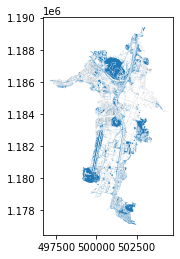

In [4]:
green.plot()

In [5]:
initial_buffer = 250
buffered = tess.buffer(initial_buffer)
distance = []
for orig, geom in tqdm(zip(tess.tessellation, buffered.geometry), total=len(buffered)):
    query = green.sindex.query(geom, predicate='intersects')
    b = initial_buffer
    while query.size == 0:
        query = green.sindex.query(geom.buffer(b), predicate='intersects')
        b += initial_buffer
    
    distance.append(green.iloc[query].distance(orig).min())

100%|██████████| 337737/337737 [1:32:45<00:00, 60.68it/s]  


<AxesSubplot:>

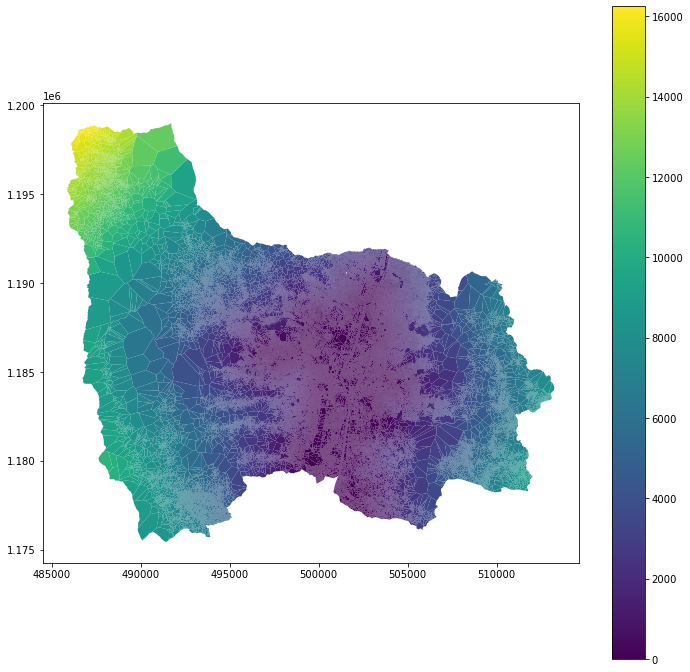

In [8]:
tess.plot(pd.Series(distance), figsize=(12, 12), legend=True)

In [9]:
func_data = pd.read_parquet('../../urbangrammar_samba/sp_sig_concept/medellin/func_data_tess.pq')

In [10]:
func_data['park_distance'] = distance

In [11]:
func_data.to_parquet('../../urbangrammar_samba/sp_sig_concept/medellin/func_data_tess.pq')

### Heritage

Heritage - Influence Area Assets of Cultural Interest (polygons)

In [42]:
download("https://opendata.arcgis.com/datasets/ab822ef53aac4c0f990097978ea4ae5d_6.zip", '../../urbangrammar_samba/sp_sig_concept/medellin/heritage/areas', kind="zip")

Creating data folder...

file_sizes: 21.9kB [00:00, 6.76MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/heritage/areas


'../../urbangrammar_samba/sp_sig_concept/medellin/heritage/areas'

In [77]:
heritage_poly = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/medellin/heritage/areas').to_crs(tess.crs)

In [78]:
inp, res = tess.sindex.query_bulk(heritage_poly.geometry, predicate="intersects")
out = np.zeros(shape=tess.shape[0], dtype=np.bool_)
out[res] = True
tess["heritage_area"] = out

### Land use

In [44]:
download("https://opendata.arcgis.com/datasets/1c3e3f8adee74aa59e05a9bd610d322c_5.zip", '../../urbangrammar_samba/sp_sig_concept/medellin/land_use/urban', kind="zip")

Creating data folder...

file_sizes: 22.1MB [00:01, 19.5MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/land_use/urban


'../../urbangrammar_samba/sp_sig_concept/medellin/land_use/urban'

In [114]:
urban = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/medellin/land_use/urban').to_crs(tess.crs)

In [115]:
urban.head()

,OBJECTID,COD_CAT_US,COD_SUBCAT,AREAGRALUS,SUBCATEGOR,SHAPEAREA,SHAPELEN,geometry
0,25467,1,11,Áreas de baja mixtura,Áreas predominantemente residenciales,148477.280907,2205.041058,"POLYGON ((493517.995 1176197.957, 493519.962 1..."
1,25468,1,11,Áreas de baja mixtura,Áreas predominantemente residenciales,900.140772,134.628230,"POLYGON ((493978.956 1176420.508, 493972.951 1..."
2,25469,1,11,Áreas de baja mixtura,Áreas predominantemente residenciales,1134.230010,160.192495,"POLYGON ((494033.979 1176429.197, 494028.062 1..."
3,25470,1,11,Áreas de baja mixtura,Áreas predominantemente residenciales,765.464952,151.468195,"POLYGON ((493419.012 1176461.465, 493417.601 1..."
4,25471,1,11,Áreas de baja mixtura,Áreas predominantemente residenciales,211.468247,72.594020,"POLYGON ((493529.394 1176475.169, 493527.751 1..."


<AxesSubplot:>

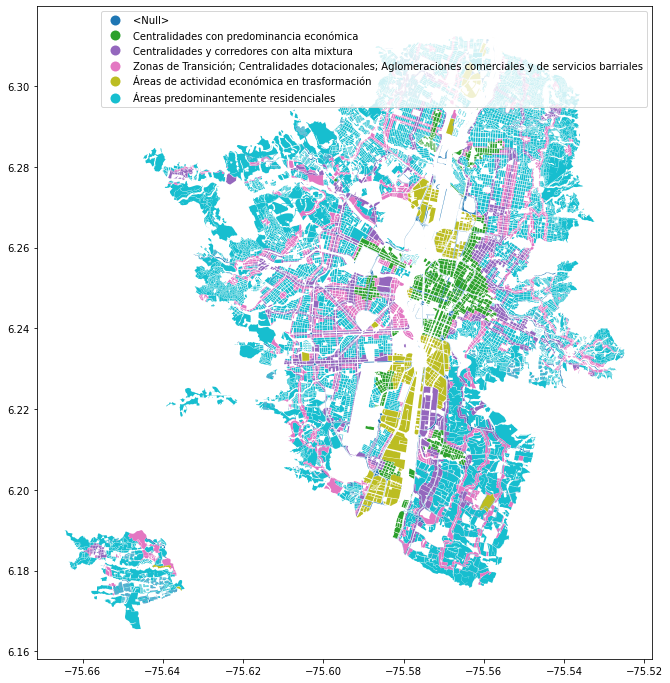

In [106]:
urban.plot("SUBCATEGOR", figsize=(12, 12), legend=True)

<AxesSubplot:>

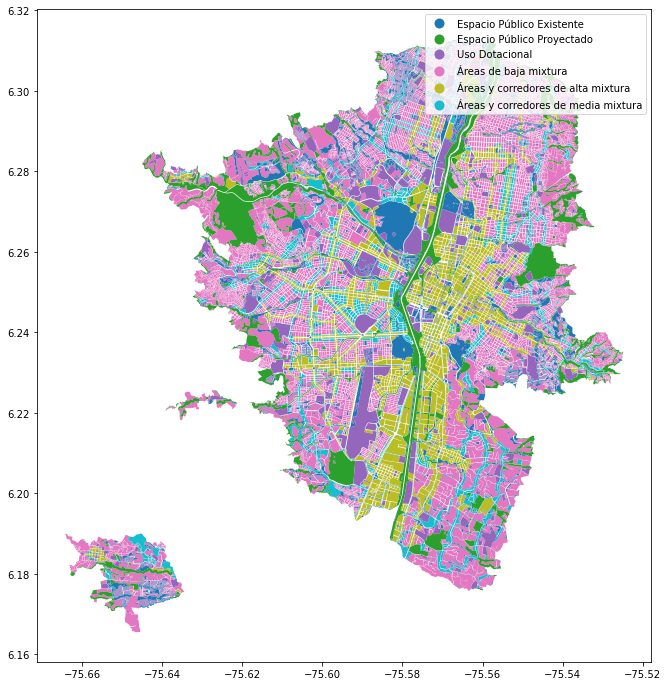

In [107]:
urban.plot("AREAGRALUS", figsize=(12, 12), legend=True)

In [118]:
urban.is_valid.all()

False

In [119]:
urban.geometry = urban.buffer(0)

In [120]:
%time tess = utils.tobler.area_max(urban, tess, ['AREAGRALUS', "SUBCATEGOR"])

CPU times: user 4min 12s, sys: 0 ns, total: 4min 12s
Wall time: 4min 12s


### POIs

In [46]:
download("https://opendata.arcgis.com/datasets/2cfddcc5e4bf415abd49560bdc36a9f7_2.zip", '../../urbangrammar_samba/sp_sig_concept/medellin/pois', kind="zip")

Creating data folder...

file_sizes: 1.04MB [00:00, 2.42MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/pois


'../../urbangrammar_samba/sp_sig_concept/medellin/pois'

In [121]:
pois = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/medellin/pois').to_crs(tess.crs)

In [68]:
pois.shape

(14495, 13)

#### accessibility to points

In [82]:
nodes = nodes.set_index('nodeID')

In [83]:
network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])

In [122]:
network.set_pois(category = 'pois',
                 maxdist = 1200,
                 maxitems=pois.shape[0],
                 x_col = pois.geometry.x, 
                 y_col = pois.geometry.y)

In [123]:
%%time
nodes['pois'] = network.nearest_pois(distance = 1200,
                               category = 'pois',
                               num_pois = pois.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 1min 36s, sys: 4.31 s, total: 1min 41s
Wall time: 1min 37s


### Public spaces

In [47]:
download("https://opendata.arcgis.com/datasets/6e54597df8f943fb983aa4c5ddb56167_20.zip", '../../urbangrammar_samba/sp_sig_concept/medellin/public_spaces', kind="zip")

Creating data folder...

file_sizes: 2.92MB [00:00, 5.72MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/public_spaces


'../../urbangrammar_samba/sp_sig_concept/medellin/public_spaces'

In [126]:
public_space = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/medellin/public_spaces').to_crs(tess.crs)

In [128]:
initial_buffer = 500
buffered = tess.buffer(initial_buffer)
distance = []
for orig, geom in tqdm(zip(tess.tessellation, buffered.geometry), total=len(buffered)):
    query = public_space.sindex.query(geom, predicate='intersects')
    b = initial_buffer
    while query.size == 0:
        query = public_space.sindex.query(geom.buffer(b), predicate='intersects')
        b += initial_buffer
    
    distance.append(public_space.iloc[query].distance(orig).min())

100%|██████████| 337737/337737 [1:24:14<00:00, 66.82it/s]  


In [129]:
tess["public_space_distance"] = distance

<AxesSubplot:>

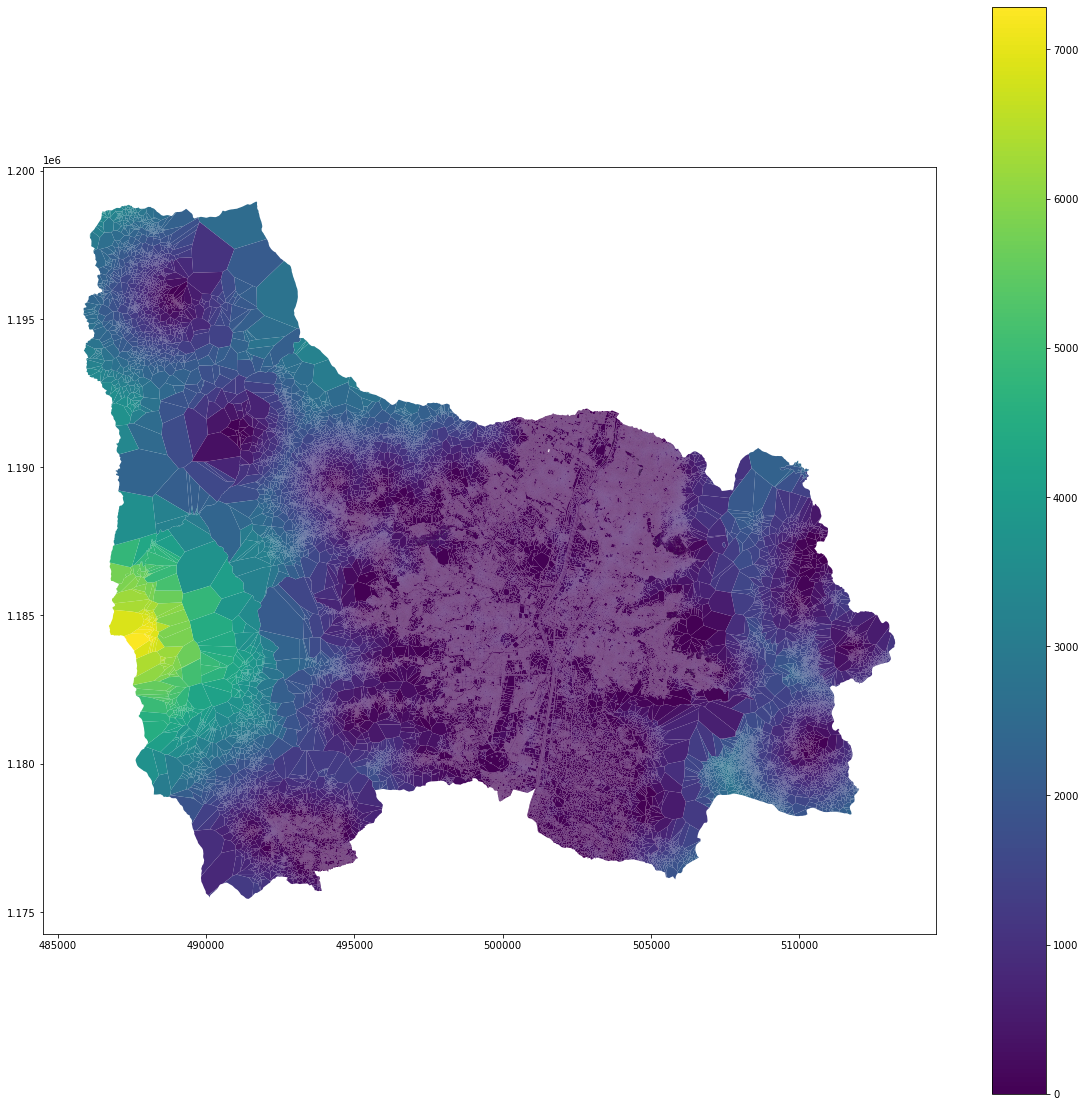

In [130]:
tess.plot("public_space_distance", figsize=(20, 20), legend=True)

### Industry and commerce

Data set made up of the geographical layer of active industrial and commercial establishments

Georeferenced information in the Massive Map Geocoder Medellín, from the addresses provided by taxpayers for their commercial establishments. It is possible to georeference 96% of the establishments.

DATE OF PUBLICATION: 18 / 11 / 2020

In [48]:
download("https://opendata.arcgis.com/datasets/aa9001f69fe846ec8b1c59bbfe222e33_0.zip", '../../urbangrammar_samba/sp_sig_concept/medellin/industry_commerce', kind="zip")

Creating data folder...

file_sizes: 6.93MB [00:00, 9.84MB/s]                                            
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/medellin/industry_commerce


'../../urbangrammar_samba/sp_sig_concept/medellin/industry_commerce'

In [131]:
commerce = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/medellin/industry_commerce').to_crs(tess.crs)

In [146]:
%%time
network.set_pois(category = 'commerce',
                 maxdist = 1200,
                 maxitems=50000,
                 x_col = commerce.geometry.x, 
                 y_col = commerce.geometry.y)

CPU times: user 6min 32s, sys: 1.19 s, total: 6min 33s
Wall time: 6min 31s


In [147]:
%%time
nodes['commerce'] = network.nearest_pois(distance = 1200,
                               category = 'commerce',
                               num_pois = 50000,
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 5min 50s, sys: 19.6 s, total: 6min 10s
Wall time: 5min 57s


In [148]:
nodes['commerce'].max()  # should be smalelr than maxitems

35798

<AxesSubplot:ylabel='Frequency'>

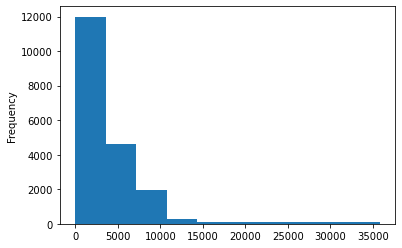

In [149]:
nodes['commerce'].plot.hist()

### Population

In [60]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020_Constrained/2020/BSGM/COL/col_ppp_2020_constrained.tif", '../../urbangrammar_samba/sp_sig_concept/medellin/population/col_ppp_2020_constrained.tif')


file_sizes: 100%|██████████████████████████| 27.8M/27.8M [00:02<00:00, 10.4MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/medellin/population/col_ppp_2020_constrained.tif


'../../urbangrammar_samba/sp_sig_concept/medellin/population/col_ppp_2020_constrained.tif'

In [3]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/COL/col_ppp_2020.tif", '../../urbangrammar_samba/sp_sig_concept/medellin/population/col_ppp_2020.tif')


file_sizes: 100%|████████████████████████████| 615M/615M [00:53<00:00, 11.5MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/medellin/population/col_ppp_2020.tif


'../../urbangrammar_samba/sp_sig_concept/medellin/population/col_ppp_2020.tif'

In [174]:
tess.drop(columns="tessellation").to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/func_data_tess.pq")

<ipython-input-174-0c8e75f299b6>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tess.drop(columns="tessellation").to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/func_data_tess.pq")


In [176]:
nodes[["heritage", "pois", "commerce"]].to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/func_data_nodes.pq")

In [5]:
pop = xarray.open_rasterio('../../urbangrammar_samba/sp_sig_concept/medellin/population/col_ppp_2020.tif')

In [6]:
pop.rio.crs

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


CRS.from_epsg(4326)

In [8]:
pop_proj = pop.rio.reproject(tess.crs)

In [9]:
pop_clip = pop_proj.rio.clip_box(*tess.total_bounds)

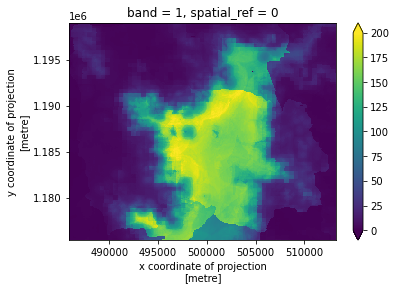

In [13]:
pop_clip.plot(vmin=0, vmax=200)

In [22]:
pop_clip.rio.to_raster('../../urbangrammar_samba/sp_sig_concept/medellin/population/col_ppp_2020_proj.tif')

In [17]:
arr = pop_clip.values

In [27]:
affine = pop_clip.rio.transform()

In [21]:
affine

Affine(92.41997542176702, 0.0, 485833.21591614693,
       0.0, -92.41997542176726, 1198984.4155019412)

In [26]:
arr[0].shape

(255, 297)

In [35]:
%%time 
stats = rasterstats.zonal_stats(
    tess.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean', "min", "max", "median"],
    all_touched=True,
)

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 5min 34s, sys: 9.95 s, total: 5min 44s
Wall time: 5min 44s


In [36]:
stats

[{'min': 157.2313690185547,
  'max': 159.74676513671875,
  'mean': 158.48906707763672,
  'median': 158.48906707763672},
 {'min': 157.2313690185547,
  'max': 157.2313690185547,
  'mean': 157.2313690185547,
  'median': 157.2313690185547},
 {'min': 157.2313690185547,
  'max': 159.75941467285156,
  'mean': 158.49539184570312,
  'median': 158.49539184570312},
 {'min': 159.75941467285156,
  'max': 159.75941467285156,
  'mean': 159.75941467285156,
  'median': 159.75941467285156},
 {'min': 159.74676513671875,
  'max': 159.74676513671875,
  'mean': 159.74676513671875,
  'median': 159.74676513671875},
 {'min': 159.75941467285156,
  'max': 159.75941467285156,
  'mean': 159.75941467285156,
  'median': 159.75941467285156},
 {'min': 157.2313690185547,
  'max': 157.2313690185547,
  'mean': 157.2313690185547,
  'median': 157.2313690185547},
 {'min': 157.2313690185547,
  'max': 157.2313690185547,
  'mean': 157.2313690185547,
  'median': 157.2313690185547},
 {'min': 159.74676513671875,
  'max': 159.7594

In [37]:
tess['population'] = [x['mean'] for x in stats]

<AxesSubplot:>

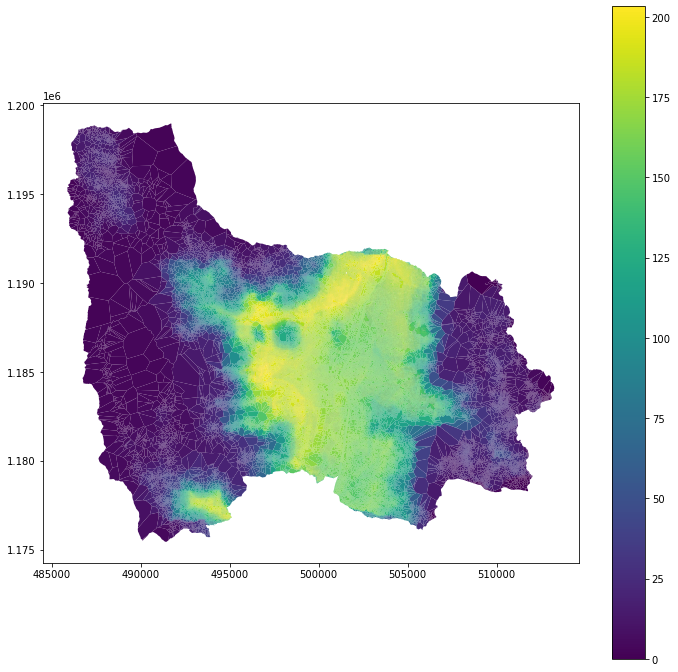

In [38]:
tess.plot('population', figsize=(12, 12), legend=True, missing_kwds={"color": 'r'}, vmin=0)

In [39]:
data = pd.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/func_data_tess.pq")

In [40]:
data['population'] = [x['mean'] for x in stats]

In [43]:
mask = data.population < 0
data.population[mask] = 0

<ipython-input-43-2f3b25463834>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.population[mask] = 0


In [44]:
data.population.min()

0.0

In [45]:
data.to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/func_data_tess.pq")

### NDVI

Download and reproject mosaic.

In [2]:
local_dir = "../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/"

In [3]:
tiles = geopandas.read_file("../../data_processing/imagery/GHS-composite-S2.geojson")

In [4]:
medellin = geopandas.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/nodes.pq")

In [5]:
med_extent = geopandas.GeoSeries(box(*medellin.total_bounds), crs=medellin.crs).to_crs(tiles.crs).iloc[0]

In [6]:
meta = tiles[tiles.intersects(med_extent)]

In [7]:
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [10]:
meta

,URL,EPSG,UTMtile,minX,minY,maxX,maxY,size,size_unit,size_bytes,geometry,dst_path
997,http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...,32618,18N,398970.0,652550.0,631930.0,885510.0,3.028459,gigabytes,3251783540,"POLYGON ((-73.80819 5.90234, -73.80286 8.00923...",../../urbangrammar_samba/sp_sig_concept/ghs_co...


In [12]:
out = meta.apply(utils.process_scene, 
                   axis=1,
                   t_crs="EPSG:3117",
                   progressbar=True,
                  )

14/01/2021 14:21:06 | Working on Tile 18N - File: S2_percentile_30_UTM_557-0000000000-0000023296.tif
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
	14/01/2021 14:21:06 | rio warp ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_557-0000000000-0000023296.tif ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_557-0000000000-0000023296_osgb.tif --threads 16 --dst-crs EPSG:3117
	14/01/2021 14:27:38 | rm ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_557-0000000000-0000023296.tif
	Split-opt.
		14/01/2021 14:30:09 | Optimising S2_percentile_30_UTM_557-0000000000-0000023296_wm_R.tif


		14/01/2021 14:33:15 | Optimising S2_percentile_30_UTM_557-0000000000-0000023296_wm_G.tif


		14/01/2021 14:36:13 | Optimising S2_percentile_30_UTM_557-0000000000-0000023296_wm_B.tif


		14/01/2021 14:39:23 | Optimising S2_percentile_30_UTM_557-0000000000-0000023296_wm_I.tif


In [2]:
medellin = geopandas.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/tessellation.pq")
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_557-0000000000-0000023296_osgb.tif")

In [3]:
medellin.crs.equals(r.rio.crs)

True

In [4]:
clipped = r.rio.clip_box(*medellin.total_bounds)
masked = clipped.where(clipped != 0)

In [5]:
ndvi = (masked.sel(band=4) - masked.sel(band=1)) / (masked.sel(band=4) + masked.sel(band=1))

In [6]:
ndvi.min(), ndvi.max()

(<xarray.DataArray ()>
 array(-0.45150774)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(0.84324537)
 Coordinates:
     spatial_ref  int64 0)

In [7]:
affine = ndvi.rio.transform()

In [10]:
%%time
stats = rasterstats.zonal_stats(
    medellin.geometry, 
    raster=ndvi.values,
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 8min 27s, sys: 19.3 s, total: 8min 46s
Wall time: 8min 46s


In [11]:
medellin['ndvi'] = [x["mean"] for x in stats]

In [12]:
medellin[["tID", "ndvi"]].to_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/ndvi.pq")

<AxesSubplot:>

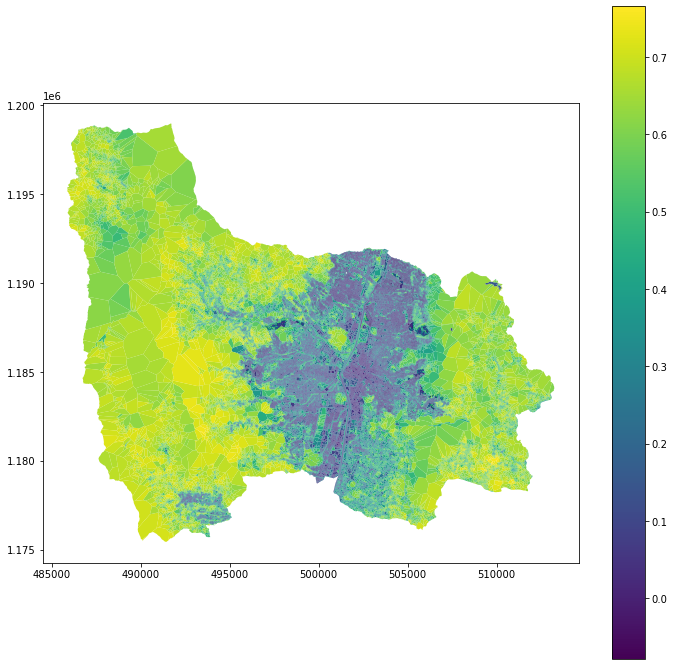

In [13]:
medellin.plot('ndvi', legend=True, figsize=(12, 12))